# Fake News Detector

This machine learning model takes in News headlines as input, and gives the authencity prediction as an output.

## Importing Libraries 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import numpy as np
import random
import csv
import pandas as pd

## Importing the data

In [2]:
#Gets the current working directory(This notebook was saved in the ~/Python folder)
#To get to the downloaded dataset, we need to go to the ~/Downloads folder
data_path = f"{os.getcwd()}/../Downloads/fake-news.zip"
#shutil.rmtree('news')
#Uncomment the above to remove the ~/news directory if re-importing the data.

#Extracts the training data from zip files. Extracts all the files in the ~/news directory.
local_zip = data_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('news')
zip_ref.close()

## Reading the data from the csv files

In [3]:
#Saving the sentences and the labels in lists called sentences and labels
#We append 1 to the labels if the news headline was true, 0 if it was false.
sentences = []
labels = []
cols=["text", "label"]
df=pd.read_csv("news/train.csv", usecols=cols)

In [4]:
#Reading the first 10 instances of data.
print(df[:10])
print(len(df))

                                                text  label
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1
1  Ever get the feeling your life circles the rou...      0
2  Why the Truth Might Get You Fired October 29, ...      1
3  Videos 15 Civilians Killed In Single US Airstr...      1
4  Print \nAn Iranian woman has been sentenced to...      1
5  In these trying times, Jackie Mason is the Voi...      0
6  Ever wonder how Britain’s most iconic pop pian...      1
7  PARIS  —   France chose an idealistic, traditi...      0
8  Donald J. Trump is scheduled to make a highly ...      0
9  A week before Michael T. Flynn resigned as nat...      0
20800


## Pre-processing the data

In [5]:
#Keep the split size to be 90% of the entire dataset.
spl=0.9 #change this variable to change the train-test split
split_size = int(spl * len(df))
#Extracting the headlines and label attributes from the dictionary
headlines = list(df.astype(str)['text'])
labels = df['label']
#Split the data so that 90% of it is the training set, and 10% is the testing set.
x_train = headlines[: split_size]
y_train = labels[: split_size]
x_val = headlines[split_size: ]
y_val = labels[split_size: ]
print(len(x_train))
print(len(x_val))

18720
2080


In [6]:
#Turning the headline data into a list, and the labels into an 1D array
x_train = list(x_train)
y_train = np.array(y_train)
x_val = list(x_val)
y_val = np.array(y_val)

In [7]:
#Confirming that the headline data and labels are in the correct format
print(x_train[:10])
print(y_train[:10])

['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing ema

In [8]:
#Importing pre-processing functions.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
#We tokenize the entire text corpus into 20000 words, fit it onto the headlines, and generate the word index.
tokenizer = Tokenizer(num_words = 20000, oov_token = '<OOV>')
tokenizer.fit_on_texts(headlines)
word_index = tokenizer.word_index

#Making the train and test sequences form the tokenizer
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_val)

In [10]:
#Padding the train and validation sequences to a legth of 200, with truncating set to "post".
train_padded = pad_sequences(train_sequences, padding = 'post', maxlen = 300, truncating = 'post')
validation_padded = pad_sequences(test_sequences, padding = 'post', maxlen = 300, truncating = 'post')

In [11]:
#The dimensions of the data is checked.
print(train_padded.shape)
print(validation_padded.shape)
y_train = np.asarray(y_train).astype('float32').reshape((len(y_train)))
y_test = np.asarray(y_val).astype('float32').reshape((len(y_val)))
print(y_train.shape)
print(y_test.shape)

(18720, 300)
(2080, 300)
(18720,)
(2080,)


## Preparing and compiling the model

In [12]:
#Making a Bidirectional LSTM model with 2 hidden dense layers.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 32, input_length = 300),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, input_shape=(None, 300))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = tf.nn.relu),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 32)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [13]:
#compiling the model with hyperparameters.
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Training the model with the train and test data

In [14]:
history = model.fit(train_padded, y_train, epochs = 15, batch_size=128, validation_data = (validation_padded, y_test), verbose=1)

Epoch 1/15
147/147 [==============================] - 58s 377ms/step - loss: 0.2883 - accuracy: 0.8753 - val_loss: 0.1123 - val_accuracy: 0.9615
Epoch 2/15
147/147 [==============================] - 54s 370ms/step - loss: 0.0640 - accuracy: 0.9782 - val_loss: 0.0824 - val_accuracy: 0.9716
Epoch 3/15
147/147 [==============================] - 55s 374ms/step - loss: 0.0223 - accuracy: 0.9934 - val_loss: 0.1503 - val_accuracy: 0.9433
Epoch 4/15
147/147 [==============================] - 50s 342ms/step - loss: 0.0129 - accuracy: 0.9963 - val_loss: 0.1638 - val_accuracy: 0.9601
Epoch 5/15
147/147 [==============================] - 50s 339ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.1950 - val_accuracy: 0.9582
Epoch 6/15
147/147 [==============================] - 43s 296ms/step - loss: 0.0059 - accuracy: 0.9983 - val_loss: 0.1572 - val_accuracy: 0.9625
Epoch 7/15
147/147 [==============================] - 48s 327ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.1379 - val_ac

## Seeing the results

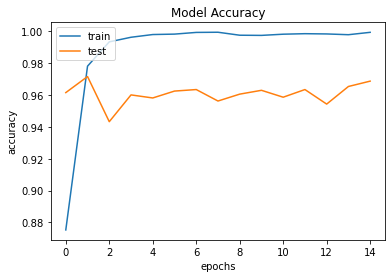

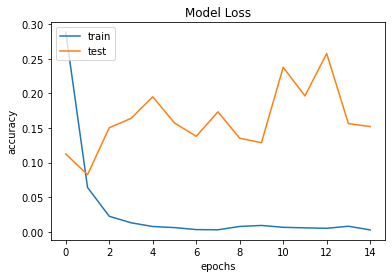

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()